In [73]:
import os
os.environ['MKL_ENABLE_INSTRUCTIONS'] = 'SSE4_2'
import warnings
warnings.filterwarnings("ignore", message="Intel MKL WARNING*")
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from lightgbm import LGBMRegressor
import lightgbm
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import RandomizedSearchCV
import plotly.express as px
from scipy import stats
import ta
import numba
from scipy.fft import fft
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer

In [3]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [87]:
# Constants
returnInterval = 60  # 1 day in minutes
rolling_window = 20160  # 2 weeks of minute data (2016 minutes)
forecast_period = 1440  # 1 day of minute data (1008 minutes)

# Load and prepare BTC data
btc_df = pd.read_parquet("data/BTCUSDT.pq")
btc_df = btc_df.sort_values(by="time")
btc_df["return"] = btc_df["close"].diff(returnInterval)  # Calculate returns
btc_df = btc_df.dropna()  # Drop NaN values
btc_df.reset_index(drop=True, inplace=True)

# train_time = pd.to_datetime("09/01/24")

if not os.path.exists("market_neutral/"):
    os.mkdir("market_neutral/")

for filename in os.listdir("data/"):
    if filename.endswith(".pq") and filename != "BTCUSDT.pq":
        x_df = pd.read_parquet(os.path.join("data/", filename))
        x_df = x_df.sort_values(by="time")
        x_df["return"] = x_df["close"].diff(returnInterval)  # Calculate returns
        x_df = x_df.dropna()  # Drop NaN values

        if (x_df.shape[0] != btc_df.shape[0]) or (not all(btc_df.time.values == x_df.time.values)):
            continue
        
        # Initialize lists to store results
        mn_returns = []
        mn_closes = []

        # Loop through the dataset in weekly increments
        for i in range(rolling_window, len(btc_df) - forecast_period, forecast_period):
            # Define training window for beta calculation
            X_train = btc_df["return"].iloc[i-rolling_window:i].values.reshape(-1, 1)
            y_train = x_df["return"].iloc[i-rolling_window:i].values
            
            # Fit linear regression model to calculate beta
            model = LinearRegression().fit(X_train, y_train)

            # Print the beta value (slope)
            print(f"Day starting at index {i}: Beta calculated: {model.coef_[0]}")

            # Normalize returns for the next week using the calculated beta
            next_week_index = range(i, i + forecast_period)
            X_next_week = btc_df["return"].iloc[next_week_index].values.reshape(-1, 1)
            X_next_week_close = btc_df["close"].iloc[next_week_index].values.reshape(-1, 1)

            mn_return = x_df["return"].iloc[next_week_index] - model.coef_[0] * X_next_week.flatten()
            mn_close = x_df["close"].iloc[next_week_index] - model.coef_[0] * X_next_week_close.flatten()
            mn_returns.extend(mn_return)
            mn_closes.extend(mn_close)

        # Create DataFrame for market neutral results
        MN_x = pd.DataFrame({
            "time": x_df["time"].iloc[rolling_window:len(mn_returns) + rolling_window].values,
            "close": x_df["close"].iloc[rolling_window:len(mn_returns) + rolling_window].values,
            "mn_close": mn_closes,
            "mn_return": mn_returns,
            "volume": x_df["volume"].iloc[rolling_window:len(mn_returns) + rolling_window].values,
            "turnover": x_df["turnover"].iloc[rolling_window:len(mn_returns) + rolling_window].values,
        })

        MN_x.reset_index(drop=True, inplace=True)
        
        MN_x.to_parquet(f"market_neutral/MN_{filename[:-3]}.pq")

Week starting at index 20160: Beta calculated: 2.5519159386126306e-06
Week starting at index 21600: Beta calculated: 2.543612231229199e-06
Week starting at index 23040: Beta calculated: 2.630262186898524e-06
Week starting at index 24480: Beta calculated: 2.8648458868200303e-06
Week starting at index 25920: Beta calculated: 3.002598979063699e-06
Week starting at index 27360: Beta calculated: 3.111569898299496e-06
Week starting at index 28800: Beta calculated: 3.0942488881556066e-06
Week starting at index 30240: Beta calculated: 2.565081490354106e-06
Week starting at index 31680: Beta calculated: 2.5415546035915052e-06
Week starting at index 33120: Beta calculated: 2.4860657442111743e-06
Week starting at index 34560: Beta calculated: 2.148151439727999e-06
Week starting at index 36000: Beta calculated: 2.1114320065045768e-06
Week starting at index 37440: Beta calculated: 2.072285710729331e-06
Week starting at index 38880: Beta calculated: 1.993770784393619e-06
Week starting at index 40320

In [89]:
mn_df = pd.read_parquet("market_neutral/MN_ALPHAUSDT.pq")
mn_df.set_index("time", inplace=True)

mn_df["y"] = (mn_df["mn_close"].shift(-returnInterval)-mn_df["mn_close"])/np.abs(mn_df["mn_close"])

mn_df["1p_lag"] = mn_df["mn_return"].shift(1 * returnInterval)
mn_df["2p_lag"] = mn_df["mn_return"].shift(2 * returnInterval)
mn_df["3p_lag"] = mn_df["mn_return"].shift(3 * returnInterval)
# mn_silly.drop(columns=["turnover"], inplace=True)
mn_df = mn_df.dropna()
def generate_features(df):
    # Ensure the dataframe is sorted by time
    
    # The mn_return column already contains 1-hour returns
    df['log_return'] = np.log(df['mn_close']/df["mn_close"].shift(1))  # Adding 1 to handle negative returns
    print("done")
    # Custom moving averages and related features
    for window in [5, 10, 20, 50, 100]:
        df[f'sma_{window}h'] = df['mn_close'].rolling(window=window*60).mean()
        df[f'ema_{window}h'] = df['mn_close'].ewm(span=window*60, adjust=False).mean()
        df[f'return_ma_{window}h'] = df['log_return'].rolling(window=window*60).mean()
        df[f'return_std_{window}h'] = df['log_return'].rolling(window=window*60).std()
        df[f'z_score_{window}h'] = (df['mn_close'] - df[f'sma_{window}h']) / df['mn_close'].rolling(window=window*60).std()
    print("done")
    # Price momentum
    for lag in [1, 5, 10, 20]:
        df[f'momentum_{lag}h'] = df['mn_close'].pct_change(lag*60)
    print("done")
    # Return autocorrelation

    @numba.jit(nopython=True)
    def autocorr(x, lag):
        return np.correlate(x[lag:] - x[lag:].mean(), x[:-lag] - x[:-lag].mean())[0] / (np.std(x[lag:]) * np.std(x[:-lag]) * len(x[lag:]))

    def rolling_autocorr(series, window, lag):
        return series.rolling(window=window).apply(lambda x: autocorr(x, lag), raw=True, engine='numba')

    # In your generate_features function:
    for lag in [1, 5, 10, 20]:
        df[f'return_autocorr_{lag}h'] = rolling_autocorr(df['log_return'], lag*120, lag*60)
    print("done")
    # Volatility measures
    df['volatility_4h'] = df['log_return'].rolling(window=240).std()
    df['volatility_1d'] = df['log_return'].rolling(window=1440).std()
    df['volatility_1w'] = df['log_return'].rolling(window=10080).std()
    print("done")
    # Range-based features
    df['daily_range'] = df['mn_close'].rolling(window=1440).max() - df['mn_close'].rolling(window=1440).min()
    df['price_range_percentile'] = (df['mn_close'] - df['mn_close'].rolling(window=1440).min()) / df['daily_range']
    print("done")
    # RSI
    df['rsi'] = ta.momentum.RSIIndicator(df['mn_close'], window=1440).rsi()
    print("done")
    # MACD
    macd = ta.trend.MACD(df['mn_close'], window_slow=26*60, window_fast=12*60, window_sign=9*60)
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()
    print("done")
    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(df['mn_close'], window=20*60)
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    df['bb_pct'] = (df['mn_close'] - df['bb_low']) / (df['bb_high'] - df['bb_low'])
    print("done")
    # Transformed features
    df['rank_price'] = df['mn_close'].rank(pct=True)
    df['ts_rank_price_1d'] = df['mn_close'].rolling(window=1440).apply(lambda x: stats.percentileofscore(x, x.iloc[-1]))
    df['price_change_rate'] = df['mn_close'].pct_change(60)  # 1-hour change rate
    print("done")
    # Volume-based features
    df['volume_ma_1d'] = df['volume'].rolling(window=1440).mean()
    df['volume_ma_1w'] = df['volume'].rolling(window=10080).mean()
    df['relative_volume'] = df['volume'] / df['volume_ma_1d']
    print("done")
    # Turnover-based features
    df['turnover_ma_1d'] = df['turnover'].rolling(window=1440).mean()
    df['turnover_ma_1w'] = df['turnover'].rolling(window=10080).mean()
    df['relative_turnover'] = df['turnover'] / df['turnover_ma_1d']
    print("done")
    # Fourier transforms for cyclical patterns
    # def fourier_transform(x, num_components=3):
    #     if len(x) == 0:
    #         return np.nan
    #     f = fft(x)
    #     f_abs = np.abs(f)
    #     indices = np.argsort(f_abs)[::-1][:num_components]
    #     return np.sum(f_abs[indices])  # Return the sum of the magnitudes of the top components

    # # In your generate_features function:
    # df['fourier_7d'] = df['mn_close'].rolling(window=10080).apply(fourier_transform, raw=True)
    # print("done")
    # # Fractal dimension
    # def hurst_exponent(x):
    #     lags = range(2 * 60, 100 * 60, 60)
    #     tau = [np.sqrt(np.std(np.subtract(x[lag:], x[:-lag]))) for lag in lags]
    #     poly = np.polyfit(np.log(lags), np.log(tau), 1)
    #     return poly[0] * 2.0
    
    # df['hurst_exponent'] = df['mn_close'].rolling(window=1440).apply(hurst_exponent)
    
    # Cross-sectional neutralization (assuming you have multiple assets)
    # This would typically be done across assets, but as an example:
    # df['cs_neutral_price'] = df['mn_close'] - df['mn_close'].rolling(window=1440).mean()
    df = df.dropna()
    return df

mn_df = generate_features(mn_df)

/Users/niteesh/opt/anaconda3/envs/tradingEnv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


done
done
done
done
done
done
done
done
done
done
done
done


In [90]:
mn_df.head()
print(mn_df.columns)
print(mn_df)

Index(['close', 'mn_close', 'mn_return', 'volume', 'turnover', 'y', '1p_lag',
       '2p_lag', '3p_lag', 'log_return', 'sma_5h', 'ema_5h', 'return_ma_5h',
       'return_std_5h', 'z_score_5h', 'sma_10h', 'ema_10h', 'return_ma_10h',
       'return_std_10h', 'z_score_10h', 'sma_20h', 'ema_20h', 'return_ma_20h',
       'return_std_20h', 'z_score_20h', 'sma_50h', 'ema_50h', 'return_ma_50h',
       'return_std_50h', 'z_score_50h', 'sma_100h', 'ema_100h',
       'return_ma_100h', 'return_std_100h', 'z_score_100h', 'momentum_1h',
       'momentum_5h', 'momentum_10h', 'momentum_20h', 'return_autocorr_1h',
       'return_autocorr_5h', 'return_autocorr_10h', 'return_autocorr_20h',
       'volatility_4h', 'volatility_1d', 'volatility_1w', 'daily_range',
       'price_range_percentile', 'rsi', 'macd', 'macd_signal', 'macd_diff',
       'bb_high', 'bb_low', 'bb_pct', 'rank_price', 'ts_rank_price_1d',
       'price_change_rate', 'volume_ma_1d', 'volume_ma_1w', 'relative_volume',
       'turnover_ma_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END colsample_bytree=0.7334834444556088, gamma=0.7143340896097039, learning_rate=0.06608884729488529, max_depth=7, min_child_weight=2, n_estimators=443, reg_alpha=8.324426408004218, reg_lambda=2.1233911067827616, subsample=0.6727299868828402; total time=   9.9s
[CV] END colsample_bytree=0.7334834444556088, gamma=0.7143340896097039, learning_rate=0.06608884729488529, max_depth=7, min_child_weight=2, n_estimators=443, reg_alpha=8.324426408004218, reg_lambda=2.1233911067827616, subsample=0.6727299868828402; total time=  10.0s
[CV] END colsample_bytree=0.7334834444556088, gamma=0.7143340896097039, learning_rate=0.06608884729488529, max_depth=7, min_child_weight=2, n_estimators=443, reg_alpha=8.324426408004218, reg_lambda=2.1233911067827616, subsample=0.6727299868828402; total time=  10.3s
[CV] END colsample_bytree=0.749816047538945, gamma=4.75357153204958, learning_rate=0.07419939418114051, max_depth=7, min_child_weight=5, 

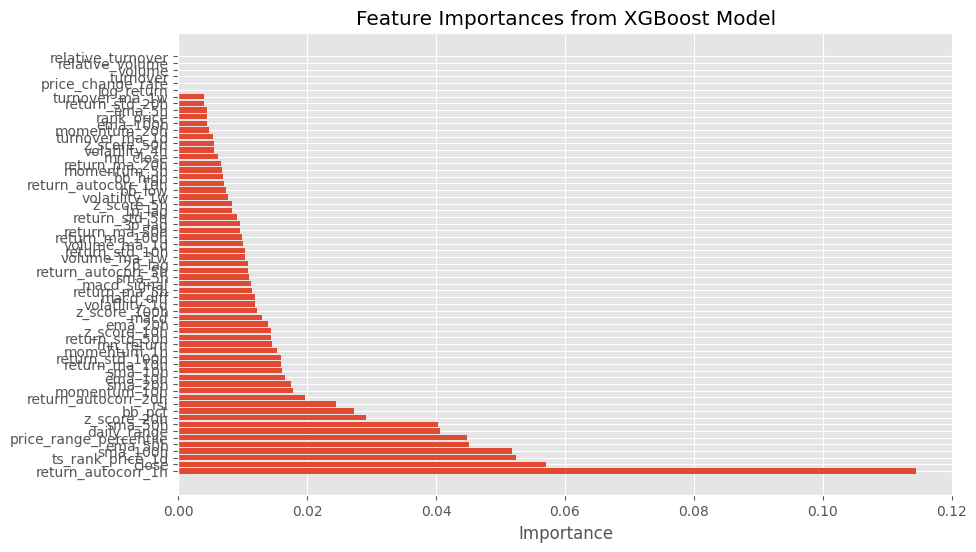

In [94]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import RobustScaler

# Assuming your DataFrame is called 'mn_df' and time is the index
mn_df.index = pd.to_datetime(mn_df.index)

# Split the data
train_data = mn_df[mn_df.index < '2024-09-01']
test_data = mn_df[mn_df.index >= '2024-09-01']

# Prepare features and target
features = [col for col in mn_df.columns if col != 'y']
X = mn_df[features]
y = mn_df['y']

# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Create time-based splits for cross-validation
n_splits = 5
split_size = len(train_data) // (n_splits + 1)
test_folds = np.repeat(-1, len(train_data))

for i in range(n_splits):
    test_folds[i*split_size:(i+1)*split_size] = i

cv = PredefinedSplit(test_fold=test_folds)

# Define a custom scorer function for MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mape, greater_is_better=False)  # MAPE should be minimized

# Define the parameter space with regularization and lower learning rate
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.001, 0.1),  # Lower learning rate
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 5),  # Increase gamma for regularization
    'reg_lambda': uniform(0, 10),  # L2 regularization term
    'reg_alpha': uniform(0, 10)     # L1 regularization term
}

# Initialize XGBoost model
xgb_model = XGBRegressor(random_state=42)

# Set up RandomizedSearchCV with MAPE as the scoring metric
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring=mape_scorer,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV to find the best parameters
random_search.fit(X_scaled, y)

# Get the best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best parameters found:")
print(best_params)

# Time series cross-validation error calculation for training and CV errors
train_errors = []
cv_errors = []

for train_idx, val_idx in cv.split(X_scaled):
    # Fit the model on the training data for this fold
    xgb_model.fit(X_scaled[train_idx], y.iloc[train_idx])

    # Predict on training data (for training error)
    y_pred_train_fold = xgb_model.predict(X_scaled[train_idx])
    
    # Predict on validation data (for cross-validation error)
    y_pred_val_fold = xgb_model.predict(X_scaled[val_idx])

    # Calculate errors
    train_mse_fold = mean_squared_error(y.iloc[train_idx], y_pred_train_fold)
    cv_mse_fold = mean_squared_error(y.iloc[val_idx], y_pred_val_fold)

    train_errors.append(train_mse_fold)
    cv_errors.append(cv_mse_fold)

# Output training and CV errors for each fold
print("\nCross-Validation Errors:")
for i in range(n_splits):
    print(f"Fold {i + 1} - Training MSE: {train_errors[i]:.4f}, CV MSE: {cv_errors[i]:.4f}")

print("\nOverall Training MSE:", np.mean(train_errors))
print("Overall CV MSE:", np.mean(cv_errors))

# Evaluate on test data using the best model
y_pred_test = best_model.predict(scaler.transform(test_data[features]))
test_mape = mape(test_data['y'], y_pred_test)

print(f"\nTest MAPE: {test_mape:.4f}%")

# Feature importance visualization
import matplotlib.pyplot as plt

importance = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from XGBoost Model')
plt.show()

[0.00041318 0.00041318 0.00041318 ... 0.00041318 0.00041318 0.00041318]

Model Performance:
Root Mean Squared Error: 0.08510459244721928
Mean Absolute Percentage Error: 116.76976716306054%
R² Score: 0.41448975610639005
XGB Correctness: 0.5276618512573569


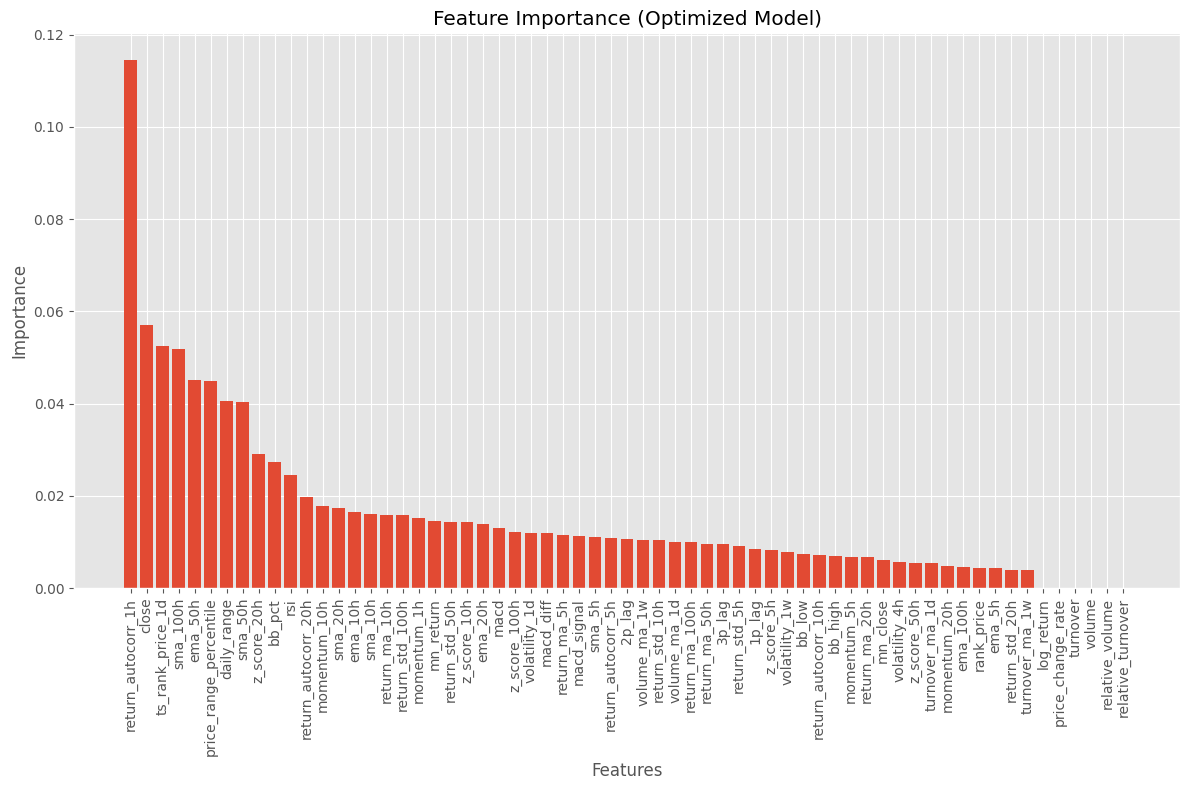


Top 10 most important features:
                   feature  importance
38      return_autocorr_1h    0.114543
0                    close    0.057071
55        ts_rank_price_1d    0.052417
29                sma_100h    0.051738
25                 ema_50h    0.045077
46  price_range_percentile    0.044859
45             daily_range    0.040565
24                 sma_50h    0.040371
23             z_score_20h    0.029115
53                  bb_pct    0.027319


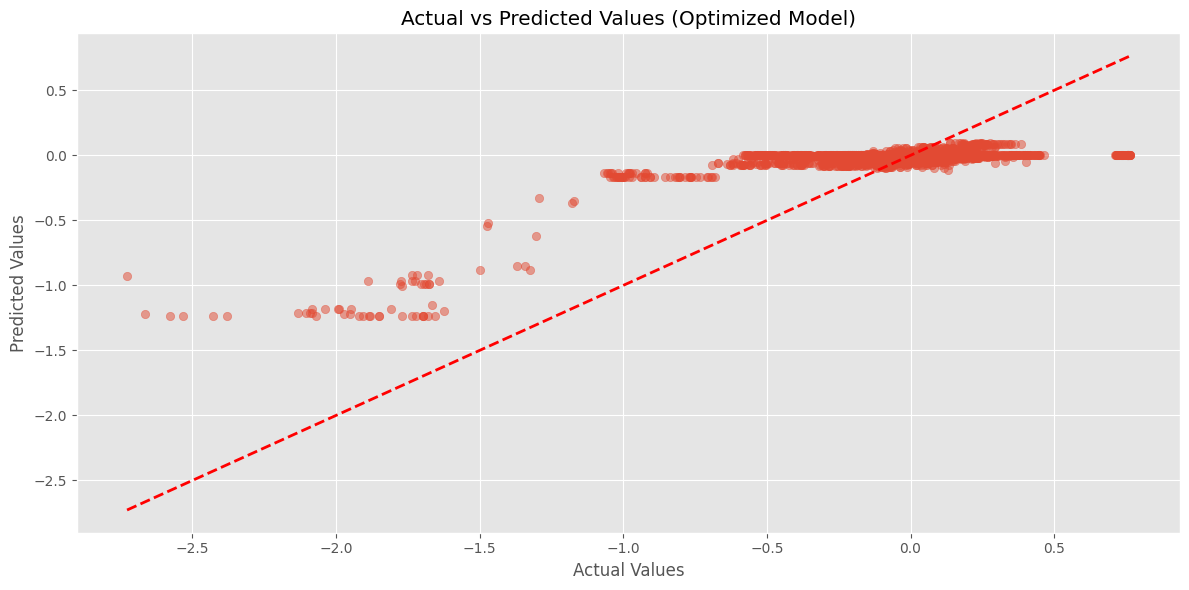

In [97]:
# Make predictions with the best model
y_pred = best_model.predict(scaler.transform(test_data[features]))
print(y_pred)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Percentage Error: {mape}%")
print(f"R² Score: {r2}")
print(f"XGB Correctness: {np.sum(np.sign(y_test) == np.sign(y_pred))/y_test.shape[0]}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance (Optimized Model)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Print top 10 most important features
print("\nTop 10 most important features:")
print(feature_importance.head(10))

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Optimized Model)')
plt.tight_layout()
plt.show()

In [ ]:
train_time = pd.to_datetime("09/01/24")
X = mn_df
print(X.columns)
X = X.drop(columns="mn_close")
X_train = X[X.index < train_time]
y_train = X_train["y"]
X_train = X_train.drop(columns=["y"])
X_test = X[X.index >= train_time]
y_test = X_test["y"]
X_test = X_test.drop(columns=["y"])

# params = {'subsample': 0.8, 'num_leaves': 100, 'n_estimators': 100, 'min_child_samples': 40, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 1.0, "verbose":-1}
params = {"verbose":-1}
lgbm_model = LGBMRegressor(**params)
lgbm_model.fit(X_train, y_train)
y_pred_train = lgbm_model.predict(X_train)
y_pred_test = lgbm_model.predict(X_test)
print(y_pred_test)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_train_linear = linear_model.predict(X_train)
y_pred_test_linear = linear_model.predict(X_test)

print(f"LGBM Train MSE: {mean_squared_error(y_pred_train, y_train)}")
print(f"LGBM Train R2: {r2_score(y_pred_train, y_train)}")
print(f"LGBM Test MSE: {mean_squared_error(y_pred_test, y_test)}")
print(f"LGBM Test R2: {r2_score(y_pred_test, y_test)}")

print(f"Linear Train MSE: {mean_squared_error(y_pred_train_linear, y_train)}")
print(f"Linear Test MSE: {mean_squared_error(y_pred_test_linear, y_test)}")

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(10,5))
ax[0].plot(y_train)
ax[0].plot(y_train.index, y_pred_train)
ax[0].plot(y_train.index, y_pred_train_linear)
ax[0].set_title("Training")
ax[0].hlines(0, y_train.index.min(), y_train.index.max(), linestyles="dashed")
ax[1].set_title("Testing")
ax[1].plot(y_test)
ax[1].plot(y_test.index, y_pred_test)
ax[1].plot(y_test.index, y_pred_test_linear)
ax[1].hlines(0, y_test.index.min(), y_test.index.max(), linestyles="dashed")
ax[0].legend(["Data", "LGBM Prediction", "Linear Prediction"])
fig.tight_layout()
fig.show()
lgbm_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_model.feature_importances_
}).sort_values('importance', ascending=False)

print("LightGBM Feature Importances:")
print(lgbm_importance)

# Feature importance for LightGBM
lgbm_importance = pd.DataFrame({
    'feature': X_train.columns,
    'lgbm_importance': lgbm_model.feature_importances_
})

# Feature importance for Linear Regression
linear_importance = pd.DataFrame({
    'feature': X_train.columns,
    'linear_importance': np.abs(linear_model.coef_)
})

# Merge the two importance dataframes
combined_importance = pd.merge(lgbm_importance, linear_importance, on='feature')

# Normalize importances to make them comparable
combined_importance['lgbm_importance_norm'] = combined_importance['lgbm_importance'] / combined_importance['lgbm_importance'].sum()
combined_importance['linear_importance_norm'] = combined_importance['linear_importance'] / combined_importance['linear_importance'].sum()

# Sort by the average of normalized importances
combined_importance['avg_importance'] = (combined_importance['lgbm_importance_norm'] + combined_importance['linear_importance_norm']) / 2
combined_importance = combined_importance.sort_values('avg_importance', ascending=False)

# Select top N features for visualization
N = 20  # You can adjust this number to show more or fewer features
top_features = combined_importance.head(N)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(top_features))
width = 0.35

ax.bar(x - width/2, top_features['lgbm_importance_norm'], width, label='LightGBM', alpha=0.7)
ax.bar(x + width/2, top_features['linear_importance_norm'], width, label='Linear Regression', alpha=0.7)

ax.set_ylabel('Normalized Importance')
ax.set_title('Feature Importance Comparison: LightGBM vs Linear Regression')
ax.set_xticks(x)
ax.set_xticklabels(top_features['feature'], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

# Print the full list of feature importances
print(combined_importance.to_string())

print(f"LGBM Correctness: {np.sum(np.sign(y_test) == np.sign(y_pred_test))/y_test.shape[0]}")
print(f"Linear Correctness: {np.sum(np.sign(y_test) == np.sign(y_pred_test_linear))/y_test.shape[0]}")

Final P&L: nan
Mean change (non-zero trades): -0.00025807961627127114
Std dev of change (non-zero trades): 0.0040719572028598775
Standard deviation of returns: 0.00118722931664511
Total trades: 43067
Average trade size: 0.9964476495726495
Max trade size: 1.0


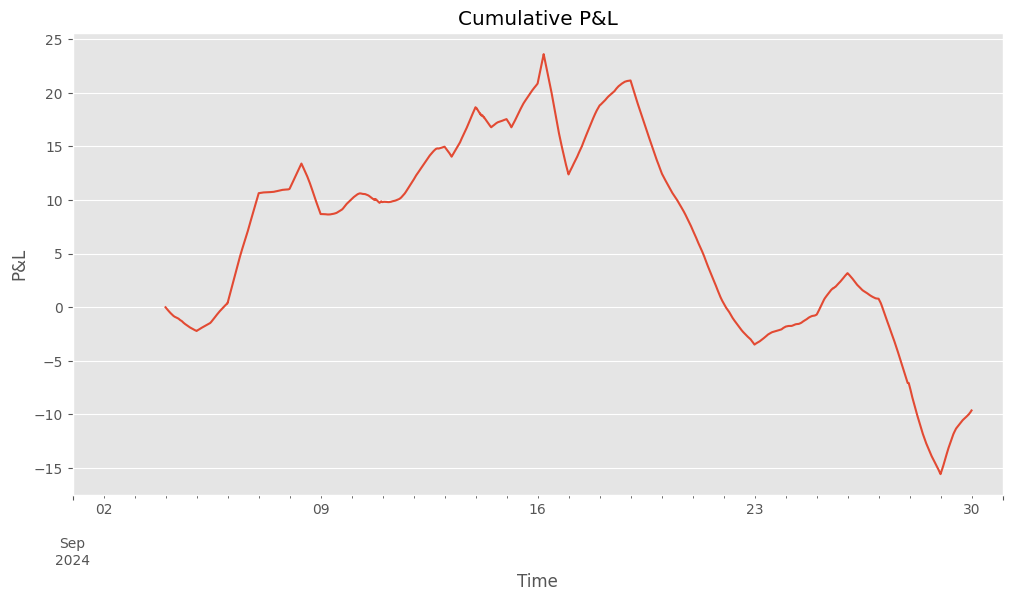

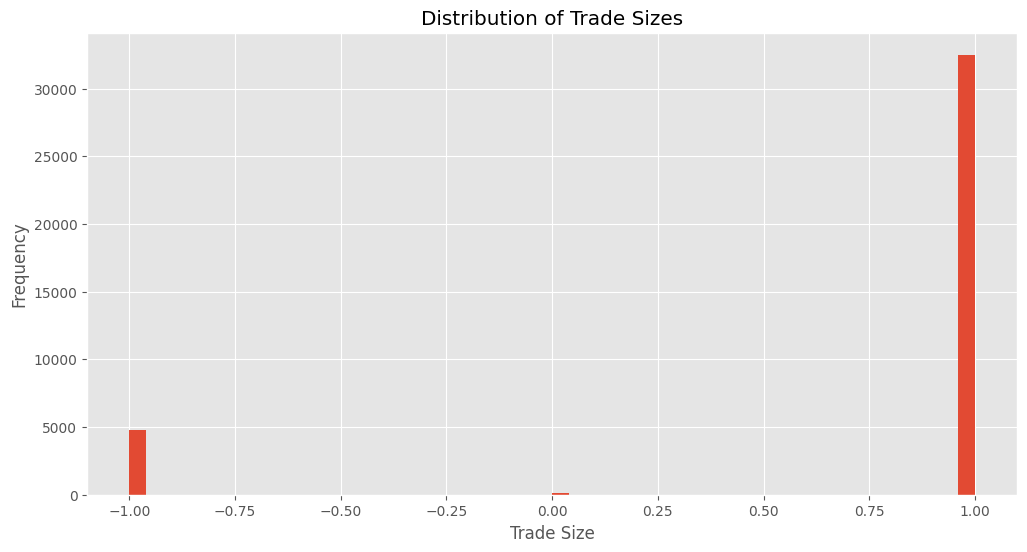

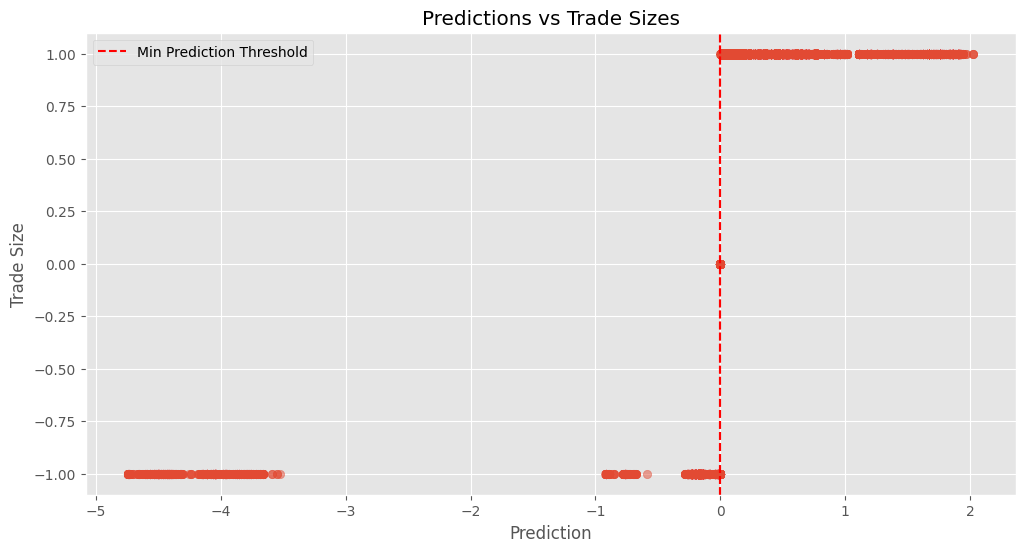

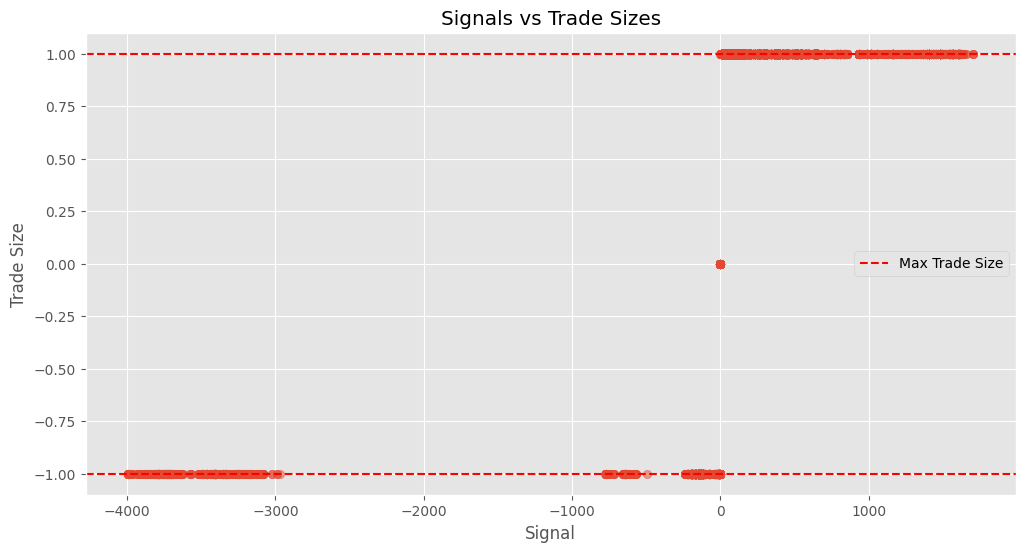

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming mn_silly, X_test, y_pred_test, and train_time are already defined

prediction = pd.DataFrame(index=X_test.index)
prediction["pred"] = y_pred
mn_df["pred"] = prediction["pred"]
mn_df = mn_df[mn_df.index >= train_time]

# Calculate standard deviation of returns using the mn_return column
returns_std = mn_df["mn_return"].std()

# Define the linear function for trade sizing
def trade_size(pred, signal, min_pred=0.0016, max_trade=1.0):
    if abs(pred) <= min_pred:
        return 0
    else:
        # Linear scaling of signal to trade size, capped at max_trade
        return np.clip(abs(signal), 0, max_trade) * np.sign(pred)

spread = 0.0012 + 0.00055
mn_df["next_change"] = mn_df["mn_close"].shift(-returnInterval) - mn_df["mn_close"]

# Calculate signal and trade size
mn_df["signal"] = mn_df["pred"] / returns_std
mn_df["trade_size"] = mn_df.apply(lambda row: trade_size(row["pred"], row["signal"], min_pred=0.0016, max_trade=1.0), axis=1)

mn_df["change"] = mn_df["trade_size"] * mn_df["next_change"] - spread * mn_df["close"] * abs(mn_df["trade_size"])
mn_df["pl"] = mn_df["change"].cumsum()

# Calculate mean and std of non-zero changes
non_zero_changes = mn_df["change"][mn_df["change"] != 0]
mean_change = non_zero_changes.mean()
std_change = non_zero_changes.std()

print(f"Final P&L: {mn_df['pl'].iloc[-1]}")
print(f"Mean change (non-zero trades): {mean_change}")
print(f"Std dev of change (non-zero trades): {std_change}")

# Additional statistics
print(f"Standard deviation of returns: {returns_std}")
print(f"Total trades: {(mn_df['trade_size'] != 0).sum()}")
print(f"Average trade size: {mn_df['trade_size'].abs().mean()}")
print(f"Max trade size: {mn_df['trade_size'].abs().max()}")

# Plot the cumulative P&L
plt.figure(figsize=(12, 6))
mn_df['pl'].plot()
plt.title('Cumulative P&L')
plt.xlabel('Time')
plt.ylabel('P&L')
plt.grid(True)
plt.show()

# Plot the distribution of trade sizes
plt.figure(figsize=(12, 6))
mn_df['trade_size'].hist(bins=50)
plt.title('Distribution of Trade Sizes')
plt.xlabel('Trade Size')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot the relationship between predictions and trade sizes
plt.figure(figsize=(12, 6))
plt.scatter(mn_df['pred'], mn_df['trade_size'], alpha=0.5)
plt.title('Predictions vs Trade Sizes')
plt.xlabel('Prediction')
plt.ylabel('Trade Size')
plt.axvline(x=0.0015, color='r', linestyle='--', label='Min Prediction Threshold')
plt.axvline(x=-0.0015, color='r', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

# Plot the relationship between signals and trade sizes
plt.figure(figsize=(12, 6))
plt.scatter(mn_df['signal'], mn_df['trade_size'], alpha=0.5)
plt.title('Signals vs Trade Sizes')
plt.xlabel('Signal')
plt.ylabel('Trade Size')
plt.axhline(y=1, color='r', linestyle='--', label='Max Trade Size')
plt.axhline(y=-1, color='r', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

In [98]:
mn_alpha = pd.read_parquet("market_neutral/MN_ALPHAUSDT.pq")
mn_alpha.set_index(mn_alpha.time, inplace=True)
mn_alpha = mn_alpha.sort_index()

prediction = pd.DataFrame(index = X_test.index)
prediction["pred"] = y_pred
# prediction["pred_linear"] = y_pred_test_linear
mn_alpha = mn_alpha[mn_alpha.index >= train_time]
mn_alpha["pred"] = prediction


spread = 0.0012 + 0.00055
mn_alpha["next_change"] = mn_alpha["mn_close"].shift(-returnInterval) - mn_alpha["mn_close"]
mn_alpha["change"] = np.where(np.abs(mn_alpha["pred"]) > 0.0016, np.where(mn_alpha["pred"] > 0, mn_alpha["next_change"], -mn_alpha["next_change"]) - spread * mn_alpha["close"], 0)
mn_alpha["pl"] = mn_alpha["change"].cumsum()

print(mn_alpha["pl"].iloc[-3])
print(mean := np.mean(mn_alpha["change"][mn_alpha["change"]!=0]))
print(std := np.std(mn_alpha["change"][mn_alpha["change"]!=0]))
print(sharpe := mean/std)

0.20460854722318847
3.2323625153742265e-05
0.0004921690316494797
0.0656758614929738


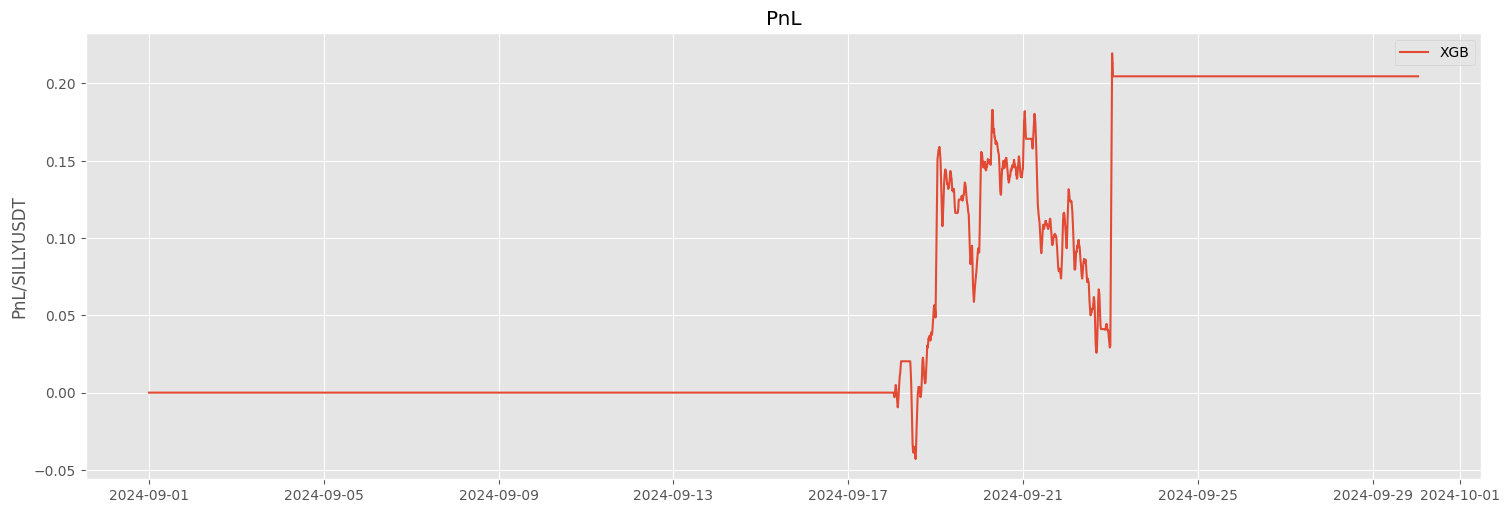

In [99]:
plt.figure(figsize=(15,5))
plt.plot(mn_alpha["pl"])
# plt.plot(mn_silly["pl_linear"])
plt.tight_layout()
plt.ylabel("PnL/SILLYUSDT")
plt.title("PnL")
plt.legend(["XGB"])
plt.show()